In [227]:
import os
import requests
import json
from dotenv import load_dotenv
import pandas as pd

import geopandas as gpd
from cartoframes.viz import Map, Layer, popup_element
from pymongo import MongoClient

import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster


In [101]:
# I need to update the documents, to add a field called location, that includes the point type and coordinates for each document.


# Connect to the MongoDB server
client = MongoClient("localhost:27017")
db = client['geospatial']

# Select the database and collection


# Update all documents to add the geometry field
dict_of_places = {'bar':13003,
                   'physiotherapy':15026,
                   'social_club':12097,
                   'tennis_store':17130,
                   'residential':12094,
                   'park': 16032,
                   'university': 12013,
                   'gym':18021,
                   'parking':19020,
                   'public_transport':19054,
                   'tennis_court':18047
                    }
# I loop through all the names of my collections in mongo.
for key in dict_of_places.keys():
    collection = db[key]
    for document in collection.find():
        lat = document["geocodes"]["main"]['latitude']
        lng = document["geocodes"]["main"]['longitude']
        geometry = {
            "type": "Point",
            "coordinates": [lng, lat]
        }
        collection.update_one({"_id": document["_id"]}, {"$set": {"geometry": geometry}})

In [102]:
client = MongoClient("localhost:27017")
db = client['geospatial']

In [103]:
districts = db.get_collection('districts_full_equip')

In [104]:
# I am going to loop through all the documents of each collection, and see what is the district containing the highest number of places.
def what_district (location):
    what_district = districts.find_one(
                                {"geometry":
                                    {"$geoIntersects": 
                                        {"$geometry": 
                                            location}}},
                            projection = {'abb_name':1})['abb_name']
    return what_district

In [133]:
list_of_results = []
for category in dict_of_places.keys():
    collection=db[category]
  
    for local in collection.find():
        new_list = []
        geometry=local['geometry']
        name = local['name']
        coordinates = geometry['coordinates']
        district_found = what_district(geometry)
        print(district_found)
        new_list = [name,category,geometry,district_found]
        list_of_results.append(new_list)
       
    

Sydney
Inner West
Sydney
Sydney
Sydney
Sydney
Sydney
Sydney
Sydney
Inner West
Woollahra
Randwick
Sydney
Inner West
Sydney
Inner West
Waverley
Burwood
Sydney
Sydney
Sydney
Sydney
Sydney
Inner West
Sydney
Willoughby
Unincorporated - Sydney Harbour Area
Sydney
Bayside
Sydney
Ryde
Fairfield
Hornsby
Canada Bay
Burwood
Canterbury-Bankstown
Inner West
Inner West
Inner West
Sydney
North Sydney
North Sydney
Sydney
Sydney
Sydney
Bayside
Sydney
Sydney
Waverley
Sutherland
Penrith
Parramatta
Cumberland
Parramatta
Parramatta
Ryde
The Hills
Canterbury-Bankstown
Canterbury-Bankstown
Hornsby
Unincorporated - Sydney Harbour Area
Canada Bay
Inner West
Northern Beaches
The Hills
Northern Beaches
Parramatta
Canada Bay
Waverley
Ryde
Fairfield
Parramatta
Cumberland
Sutherland
Blacktown
Penrith
Ryde
Northern Beaches
Canterbury-Bankstown
Burwood
Fairfield
Canterbury-Bankstown
Willoughby
Inner West
Georges River
Sydney
Georges River
Sydney
Georges River
Sydney
Ryde
Cumberland
Inner West
Willoughby
Lane Cove
Par

In [170]:
list_of_results
df_results = pd.DataFrame(list_of_results,columns=['name','category','coordinates','district'])


In [179]:
df_results

,name,category,coordinates,district
0,Opera Bar,bar,"{'type': 'Point', 'coordinates': [151.214458, ...",Sydney
1,Wayward Brewing Co.,bar,"{'type': 'Point', 'coordinates': [151.174816, ...",Inner West
2,The Potting Shed at the Grounds,bar,"{'type': 'Point', 'coordinates': [151.194181, ...",Sydney
3,The Wild Rover,bar,"{'type': 'Point', 'coordinates': [151.209629, ...",Sydney
4,The Grounds of Alexandria,bar,"{'type': 'Point', 'coordinates': [151.194368, ...",Sydney
...,...,...,...,...
300,Crown Tennis Court,tennis_court,"{'type': 'Point', 'coordinates': [151.201158, ...",Sydney
301,Kent Street Tennis Courts,tennis_court,"{'type': 'Point', 'coordinates': [151.203822, ...",Sydney
302,Darling South Ping Pong,tennis_court,"{'type': 'Point', 'coordinates': [151.202698, ...",Sydney
303,Sydney Park Village Tennis Courts,tennis_court,"{'type': 'Point', 'coordinates': [151.185803, ...",Sydney


In [201]:
grouped_district_category = df_results.groupby(['district','category']).count().reset_index()
grouped_district_category

,district,category,name,coordinates
0,Bayside,bar,1,1
1,Bayside,gym,1,1
2,Bayside,physiotherapy,1,1
3,Bayside,public_transport,1,1
4,Bayside,residential,1,1
...,...,...,...,...
136,Willoughby,tennis_court,4,4
137,Willoughby,tennis_store,1,1
138,Willoughby,university,1,1
139,Woollahra,bar,1,1


In [ ]:
'''As a businessman looking to build a paddle court club, I would weight the following items on the list in percentages:

Tennis court - 35% weight, as it is the main and essential feature of a paddle court club.
Parking - 20% weight, as having a convenient and comfortable parking area close to the paddle court club is important.
Public transport - 10% weight, as proximity to public transportation can be a consideration for the accessibility of the paddle court club.
Tennis store - 5% weight, as a nearby store selling tennis equipment and supplies can be a convenience for players.
Social club - 10% weight, as having a nearby social club can enhance the overall playing experience.
Gym - 5% weight, as a nearby gym can be a complementary addition for paddle court players.
Physiotherapy - 5% weight, as physiotherapy services can be a complementary addition for paddle court players.
Bar - 3% weight, as a nearby bar can offer an additional option for entertainment and socialization after playing.
Residential - 2% weight, as proximity to a residential area can be a consideration for accessibility and comfort.
University - 1% weight, as proximity to a university can be a consideration for accessibility and comfort.
Park - 1% weight, as proximity to a park can be a consideration for accessibility and comfort.'''

In [205]:
# I will calculate the weighted mean in each district.
def ponderate (row):
    paddle_weights = {
    "tennis_court": 35,
    "parking": 20,
    "public_transport": 10,
    "social_club": 10,
    "tennis_store": 5,
    "gym": 5,
    "physiotherapy": 5,
    "bar": 3,
    "residential": 2,
    "university": 1,
    "park": 1}
    result = row['name']*paddle_weights[row['category']]
    return result


grouped_district_category['points']=grouped_district_category.apply(ponderate,axis=1)

In [206]:
grouped_district_category

,district,category,name,coordinates,points
0,Bayside,bar,1,1,3
1,Bayside,gym,1,1,5
2,Bayside,physiotherapy,1,1,5
3,Bayside,public_transport,1,1,10
4,Bayside,residential,1,1,2
...,...,...,...,...,...
136,Willoughby,tennis_court,4,4,140
137,Willoughby,tennis_store,1,1,5
138,Willoughby,university,1,1,1
139,Woollahra,bar,1,1,3


In [213]:
final_group = grouped_district_category.groupby('district').sum('points').sort_values('points',ascending=False).reset_index()

In [216]:
final_group.drop(columns=['name','coordinates'],inplace=True)

In [219]:
final_group


,district,points
0,Sydney,492
1,Parramatta,268
2,Canterbury-Bankstown,195
3,Willoughby,185
4,Ryde,169
5,Blacktown,165
6,Inner West,137
7,North Sydney,131
8,The Hills,123
9,Hornsby,122


<AxesSubplot: xlabel='district'>

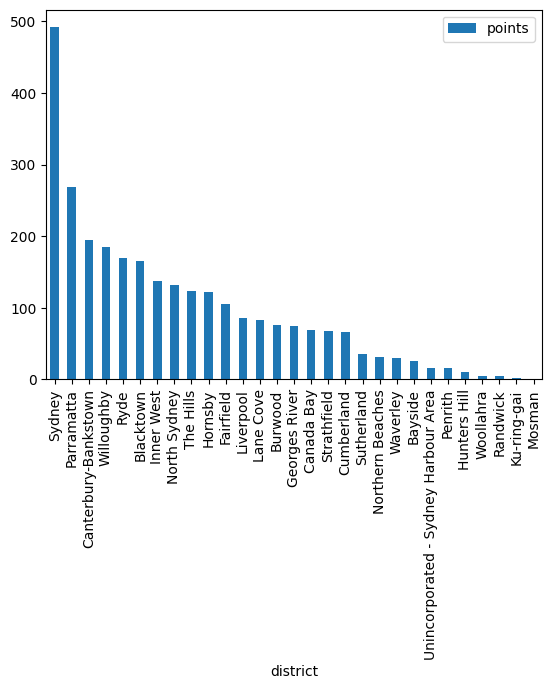

In [220]:
final_group.plot(kind='bar',x='district',y='points')

In [225]:

df_sydney_places = df_results.loc[df_results['district'] == 'Sydney', ['name', 'coordinates','category']]


In [226]:
df_sydney_places

,name,coordinates,category
0,Opera Bar,"{'type': 'Point', 'coordinates': [151.214458, ...",bar
2,The Potting Shed at the Grounds,"{'type': 'Point', 'coordinates': [151.194181, ...",bar
3,The Wild Rover,"{'type': 'Point', 'coordinates': [151.209629, ...",bar
4,The Grounds of Alexandria,"{'type': 'Point', 'coordinates': [151.194368, ...",bar
5,Harts Pub,"{'type': 'Point', 'coordinates': [151.206369, ...",bar
...,...,...,...
299,Fisher Tennis Centre,"{'type': 'Point', 'coordinates': [151.190329, ...",tennis_court
300,Crown Tennis Court,"{'type': 'Point', 'coordinates': [151.201158, ...",tennis_court
301,Kent Street Tennis Courts,"{'type': 'Point', 'coordinates': [151.203822, ...",tennis_court
302,Darling South Ping Pong,"{'type': 'Point', 'coordinates': [151.202698, ...",tennis_court


In [228]:
df_sydney_places.value_counts('category')

category
bar                 18
park                12
gym                 10
university           9
tennis_court         7
physiotherapy        6
residential          6
social_club          3
parking              2
public_transport     1
dtype: int64

In [237]:
sydney_map = Map (location = [-33.8482439, 151.185803], zoom_start = 13)
sydney_map

In [243]:

for index, row in df_sydney_places.iterrows():
    
    #1. MARKER without icon
    district = {"location": [row['coordinates']['coordinates'][1],row['coordinates']['coordinates'][0]], "tooltip": row["category"]}
    
    #2. Icon
    if row["category"] == "bar":        
        icon = Icon (
            color="blue",
            opacity = 0.6,
            prefix = "fa",
            icon="beer",
            icon_color = "black"
        )
    elif row["category"] == "tennis_court":
        icon = Icon (
            color="yellow",
            opacity = 0.6,
            prefix = "fa",
            icon="trophy",
            icon_color = "black"
        )
    elif row["category"] == "park":
        icon = Icon (
            color="green",
            opacity = 0.6,
            prefix = "fa",
            icon="leaf",
            icon_color = "black"
        )
    elif row["category"] == "gym":
        icon = Icon (
            color="darkpurple",
            opacity = 0.6,
            prefix = "fa",
            icon="bicycle",
            icon_color = "black"

        )
    elif row["category"] == "university":
        icon = Icon (
            color="white",
            opacity = 0.6,
            prefix = "fa",
            icon="university",
            icon_color = "black")

    elif row["category"] == "physiotherapy":
        icon = Icon (
            color="lightblue",
            opacity = 0.6,
            prefix = "fa",
            icon="hospital",
            icon_color = "black")
    
    elif row["category"] == "residential":
        icon = Icon (
            color="white",
            opacity = 0.6,
            prefix = "fa",
            icon="building",
            icon_color = "black")   

    elif row["category"] == "social_club":
        icon = Icon (
            color="pink",
            opacity = 0.6,
            prefix = "fa",
            icon="glass",
            icon_color = "black")   

    elif row["category"] == "parking":
        icon = Icon (
            color="brown",
            opacity = 0.6,
            prefix = "fa",
            icon="car",
            icon_color = "white") 

    elif row["category"] == "public_transport":
        icon = Icon (
            color="brown",
            opacity = 0.6,
            prefix = "fa",
            icon="car",
            icon_color = "white") 


    #3. Marker
    new_marker = Marker(**district, icon = icon, radius = 2)
    
    #4. Add the Marker
    new_marker.add_to(sydney_map)

/var/folders/ws/sd2pf4qs4vg4sl9q985777nm0000gn/T/ipykernel_41282/2930210812.py:73: UserWarning: color argument of Icon should be one of: {'cadetblue', 'blue', 'gray', 'white', 'lightgreen', 'pink', 'orange', 'lightred', 'darkblue', 'lightblue', 'darkpurple', 'purple', 'red', 'green', 'darkred', 'lightgray', 'black', 'beige', 'darkgreen'}.
  icon = Icon (
/var/folders/ws/sd2pf4qs4vg4sl9q985777nm0000gn/T/ipykernel_41282/2930210812.py:81: UserWarning: color argument of Icon should be one of: {'cadetblue', 'blue', 'gray', 'white', 'lightgreen', 'pink', 'orange', 'lightred', 'darkblue', 'lightblue', 'darkpurple', 'purple', 'red', 'green', 'darkred', 'lightgray', 'black', 'beige', 'darkgreen'}.
  icon = Icon (
/var/folders/ws/sd2pf4qs4vg4sl9q985777nm0000gn/T/ipykernel_41282/2930210812.py:16: UserWarning: color argument of Icon should be one of: {'cadetblue', 'blue', 'gray', 'white', 'lightgreen', 'pink', 'orange', 'lightred', 'darkblue', 'lightblue', 'darkpurple', 'purple', 'red', 'green', '

In [244]:
sydney_map